# Основные виды нейросетей (CNN и RNN)

**Разработчик: Алексей Умнов**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/master/week03_architectures/homework.ipynb)


Этот семинар будет состоять из двух частей: сначала мы позанимаемся реализацией сверточных и рекуррентных сетей, а потом поисследуем проблему затухающих и взрывающихся градиентов.

## Сверточные сети

Вернемся в очередной раз к датасету MNIST. Для начала загрузим данные и определим несколько полезных функций как на прошлом семинаре.

In [1]:
# Load dependencies
!wget --quiet --show-progress "https://raw.githubusercontent.com/mryab/dl-hse-ami/master/week03_architectures/util.py"

util.py             100%[===================>]   3.74K  --.-KB/s    in 0s      


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

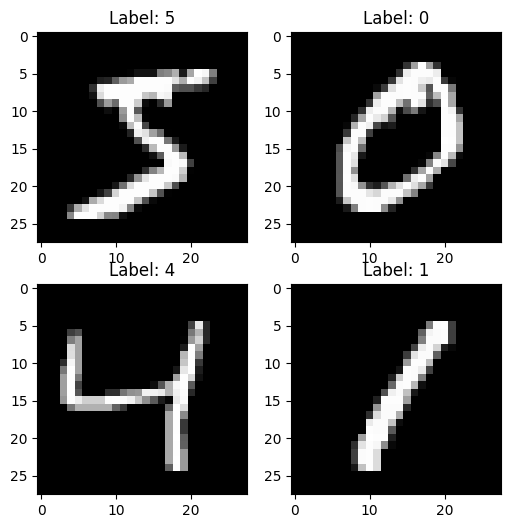

In [3]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [4]:
from util import iterate_minibatches

def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)

        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=32, shuffle=True):
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)

        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, batchsize=batchsize)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')
        print("Epoch {} error = {:.2%}".format(epoch, 1 - val_acc_log[-1][1]))

    print("Final error: {:.2%}".format(1 - val_acc_log[-1][1]))

**Задание 1:** Реализуйте сверточную сеть, которая состоит из двух последовательных применений свертки, relu и max-пулинга, а потом полносвязного слоя. Подберите параметры так, чтобы на выходе последнего слоя размерность тензора была 4 x 4 x 16. В коде ниже используется обертка nn.Sequential, ознакомьтесь с ее интерфейсом.

Добейтесь, чтобы ошибка классификации после обучения (см. ниже) была не выше 1.5%.

In [48]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5, 5)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(5,5)),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Linear(4 * 4 * 16, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return F.log_softmax(out, dim=-1)

Посчитаем количество обучаемых параметров сети (полносвязные сети с прошлого семинара имеют 30-40 тысяч параметров).

In [49]:
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

input_shape = (1,28,28)
summary(ConvNet().to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 24, 24]             104
         MaxPool2d-2            [-1, 4, 12, 12]               0
              ReLU-3            [-1, 4, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           1,616
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
            Linear-7                   [-1, 10]           2,570
Total params: 4,290
Trainable params: 4,290
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [50]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = ConvNet()
print("Total number of trainable parameters:", count_parameters(model))

Total number of trainable parameters: 4290


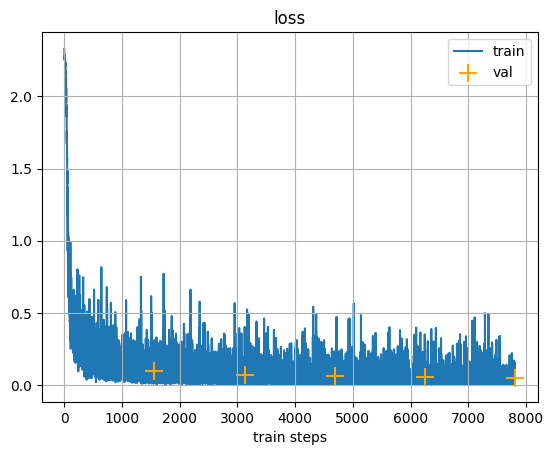

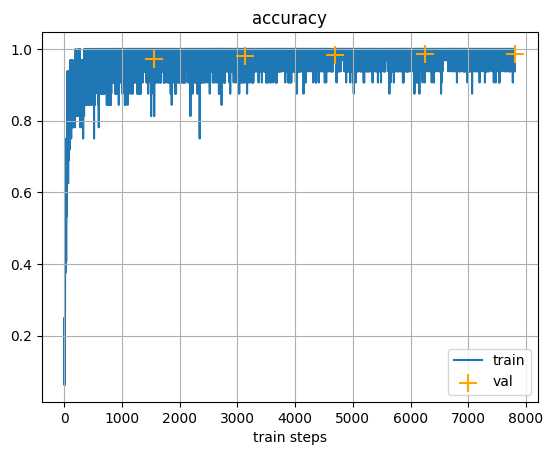

Epoch 4 error = 1.48%
Final error: 1.48%
CPU times: user 48.5 s, sys: 1.15 s, total: 49.7 s
Wall time: 51 s


In [51]:
%%time

opt = torch.optim.Adam(model.parameters(), lr=0.001)
train(model, opt, 5)

Мы с легкостью получили качество классификаци лучше, чем было раньше с помощью полносвязных сетей. На самом деле для более честного сравнения нужно поисследовать обе архитектуры и подождать побольше итераций до сходимости, но в силу ограниченности вычислительных ресурсов мы это сделать не можем. Результаты из которых "выжали максимум" можно посмотреть например, на этой странице: http://yann.lecun.com/exdb/mnist/, и там видно, что качество сверточных сетей гораздо выше. А если работать с более сложными изоражениями (например, с ImageNet), то сверточные сети побеждают с большим отрывом.

**Упражнение:** Вспомните материалы лекции и ответьте на вопросы ниже:
* Почему сверточные сети обладают таким преимуществом именно для изображений?
* Почему несмотря на малое количество параметров обучение сверточных сетей занимает так много времени?

## Рекуррентные сети

Для рекуррентных сетей используем датасет с именами и будем определять из какого языка произошло данное имя. Для этого построим рекуррентную сеть, которая с именами на уровне символов. Для начала скачаем файлы и конвертируем их к удобному формату (можно не особо вникать в этот код).

In [52]:
# На Windows придется скачать архив по ссылке (~3Mb) и распаковать самостоятельно
!wget --quiet --show-progress https://download.pytorch.org/tutorial/data.zip
!unzip -q ./data.zip

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.07s   


In [53]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

['data/names/French.txt', 'data/names/Korean.txt', 'data/names/Russian.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Dutch.txt', 'data/names/Japanese.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Irish.txt', 'data/names/Portuguese.txt', 'data/names/Chinese.txt']
Slusarski


Определим несколько удобных функций для конвертации букв и слов в тензоры.

**Задание 2**: напишите последнюю функцию для конвертации слова в тензор.

In [56]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i in range(len(line)):
      tensor[i] = letterToTensor(line[i])
    return tensor

#print(letterToTensor('J'))
print(lineToTensor('Jones'))

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

**Задание 3:** Реализуйте однослойную рекуррентную сеть.

In [57]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNCell, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = F.relu(hidden)
        return hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnncell = RNNCell(n_letters, n_hidden)

Предсказание будем осуществлять при помощи линейного класссификатора поверх скрытых состояний сети.

In [58]:
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))

Проверим, что все корректно работает: выходы классификаторы должны быть лог-вероятностями.

In [59]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input, hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8316, -2.9485, -2.8782, -2.9286, -2.9571, -2.7924, -2.8301, -2.8675,
         -2.8996, -2.8101, -2.8884, -2.8918, -2.9184, -2.9575, -2.8388, -2.9518,
         -2.9190, -2.9415]], grad_fn=<LogSoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


In [60]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output = classifier(rnncell(input[0], hidden))
print(output)
print(torch.exp(output).sum())

tensor([[-2.8316, -2.9485, -2.8782, -2.9286, -2.9571, -2.7924, -2.8301, -2.8675,
         -2.8996, -2.8101, -2.8884, -2.8918, -2.9184, -2.9575, -2.8388, -2.9518,
         -2.9190, -2.9415]], grad_fn=<LogSoftmaxBackward0>)
tensor(1., grad_fn=<SumBackward0>)


Для простоты в этот раз будем оптимизировать не по мини-батчам, а по отдельным примерам. Ниже несколько полезных функций для этого.

In [61]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Polish / line = Bobienski
category = Vietnamese / line = Giang
category = Japanese / line = Hida
category = Polish / line = Filipek
category = Czech / line = Brezovjak
category = French / line = Charron
category = Dutch / line = Lauwens
category = Portuguese / line = Alves
category = Chinese / line = Min
category = Chinese / line = Gou


**Задание 4:** Реализуйте вычисление ответа в функции train. Если все сделано правильно, то точность на обучающей выборке должна быть не менее 70%.

  0%|          | 0/50000 [00:00<?, ?it/s]

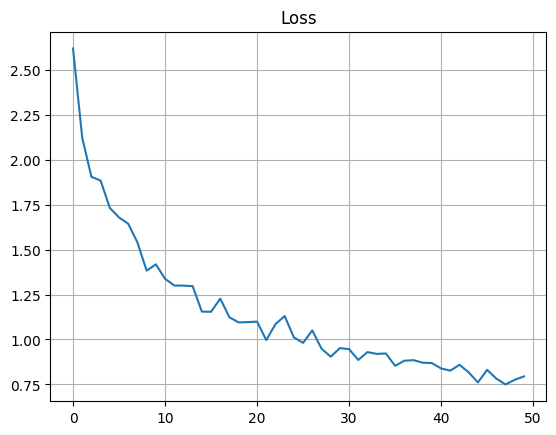

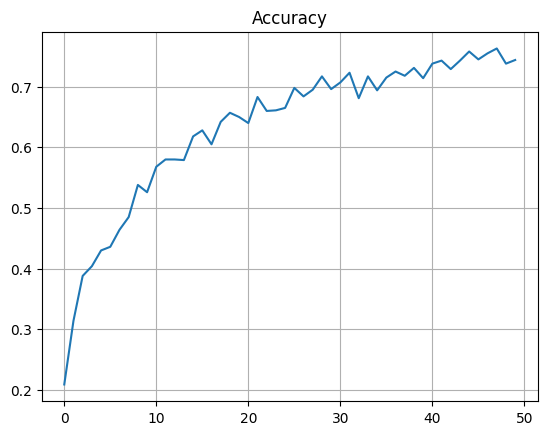

In [62]:
from tqdm.auto import tqdm

def train(category, category_tensor, line_tensor, optimizer):
    hidden = rnncell.initHidden()

    rnncell.zero_grad()
    classifier.zero_grad()

    for i in range(line_tensor.size()[0]):
      hidden = rnncell(line_tensor[i], hidden)
    output = classifier(hidden)

    loss = F.nll_loss(output, category_tensor)
    loss.backward()
    optimizer.step()

    acc = (categoryFromOutput(output)[0] == category)

    return loss.item(), acc

n_iters = 50000
plot_every = 1000

current_loss = 0
all_losses = []
current_acc = 0
all_accs = []

n_hidden = 128

rnncell = RNNCell(n_letters, n_hidden)
classifier = nn.Sequential(nn.Linear(n_hidden, n_categories), nn.LogSoftmax(dim=1))
params = list(rnncell.parameters()) + list(classifier.parameters())
opt = torch.optim.RMSprop(params, lr=0.001)
for iter in tqdm(range(1, n_iters + 1)):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    loss, acc = train(category, category_tensor, line_tensor, opt)
    current_loss += loss
    current_acc += acc

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0
        all_accs.append(current_acc / plot_every)
        current_acc = 0

plt.figure()
plt.title("Loss")
plt.plot(all_losses)
plt.grid()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(all_accs)
plt.grid()
plt.show()

## Затухающие и взрывающиеся градиенты

Эксперименты будем проводить опять на датасете MNIST, но будем работать с полносвязными сетями. В этом разделе мы не будем пытаться подобрать более удачную архитектуру, нам интересно только посмотреть на особенности обучения глубоких сетей.

In [63]:
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

Для экспериментов нам понадобится реализовать сеть, в которой можно легко менять количество слоев. Также эта сеть должна сохранять градиенты на всех слоях, чтобы потом мы могли посмотреть на их величины.

**Задание 5:** допишите недостающую часть кода ниже.

In [64]:
class DeepDenseNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation

        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]

        for i in range(1, n_layers - 1):
          l = nn.Linear(hidden_size, hidden_size)
          self.layers.append(l)
          self.weights.append(l.weight)
          self.layers.append(self.activation)

        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)
        self.layers.append(self.activation)

        self.seq = nn.Sequential(*self.layers)

        for l in self.weights:
            l.retain_grad()

    def forward(self, x):
        out = self.seq(x)
        return F.log_softmax(out, dim=-1)

Модифицируем наши функции обучения, чтобы они также рисовали графики изменения градиентов.

In [65]:
import scipy.sparse.linalg

def train_epoch_grad(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    grads = [[] for l in model.weights]
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)

        pred = torch.max(output, 1)[1].numpy()
        acc = np.mean(pred == y_batch)
        acc_log.append(acc)

        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)

        for g, l in zip(grads, model.weights):
            g.append(np.linalg.norm(l.grad.numpy()))
    return loss_log, acc_log, grads


def train_grad(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    grads_log = None

    batchsize = 32

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc, grads = train_epoch_grad(model, opt, batchsize=batchsize)
        if grads_log is None:
            grads_log = grads
        else:
            for a, b in zip(grads_log, grads):
                a.extend(b)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(X_train) / batchsize
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        # display all metrics
        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        plt.figure()
        all_vals = []
        for i, g in enumerate(grads_log):
            w = np.ones(100)
            w /= w.sum()
            vals = np.convolve(w, g, mode='valid')
            plt.semilogy(vals, label=str(i+1), color=plt.cm.coolwarm((i / len(grads_log))))
            all_vals.extend(vals)
        plt.legend(loc='best')
        plt.grid()
        plt.show()

**Задание 6:**
* Обучите сети глубины 10 и больше с сигмоидой в качестве активации. Исследуйте, как глубина влияет на качество обучения и поведение градиентов на далеких от выхода слоях.
* Теперь замените активацию на ReLU и посмотрите, что получится.

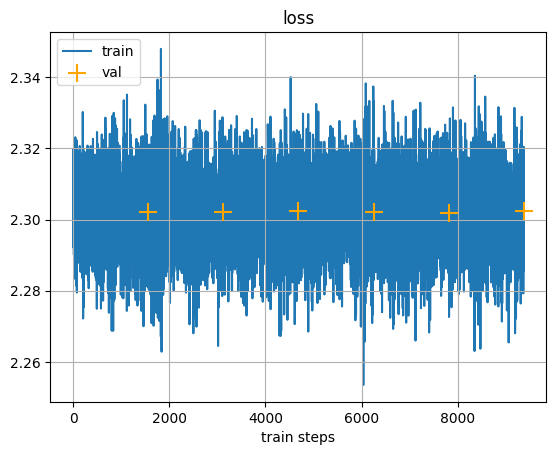

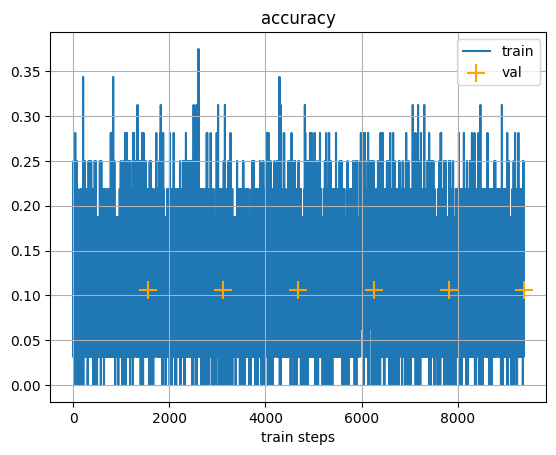

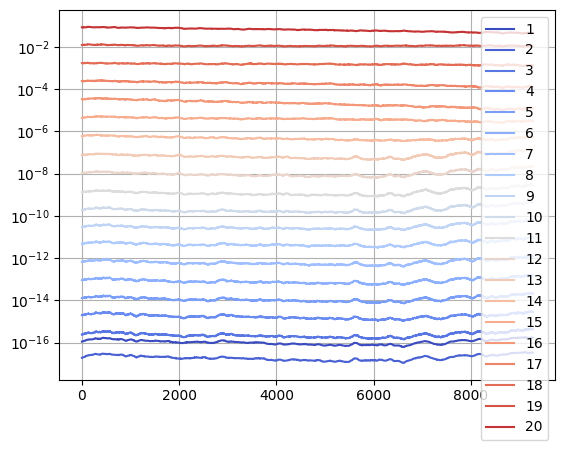

In [66]:
model = DeepDenseNet(n_layers=20, hidden_size=20, activation=nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 6)

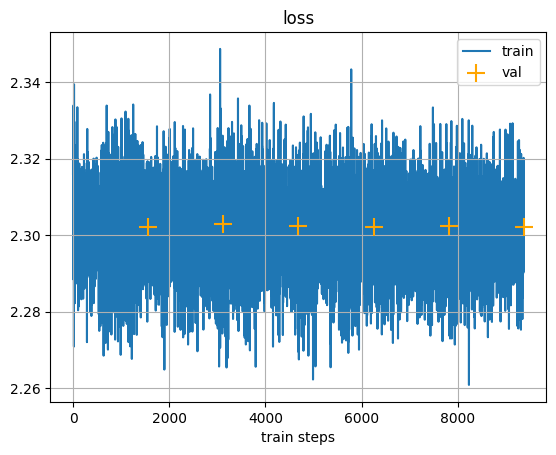

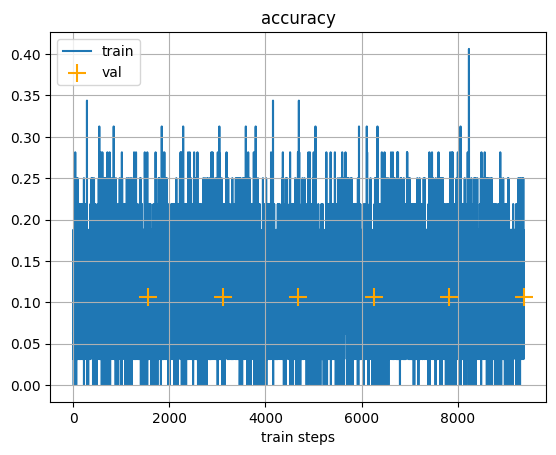

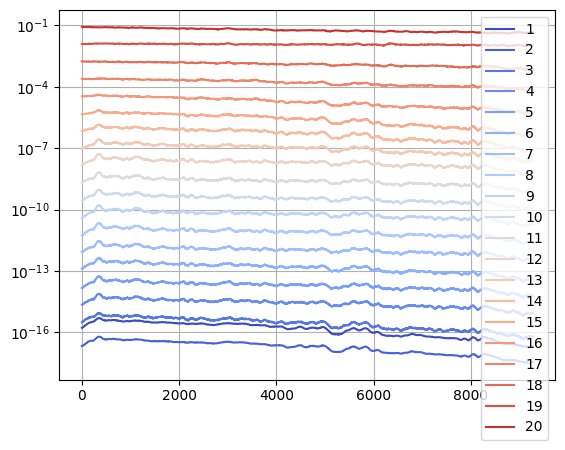

In [70]:
model = DeepDenseNet(n_layers=20, hidden_size=20, activation=nn.Sigmoid())
opt = torch.optim.Adam(model.parameters(), lr=0.001)

train_grad(model, opt, 6)

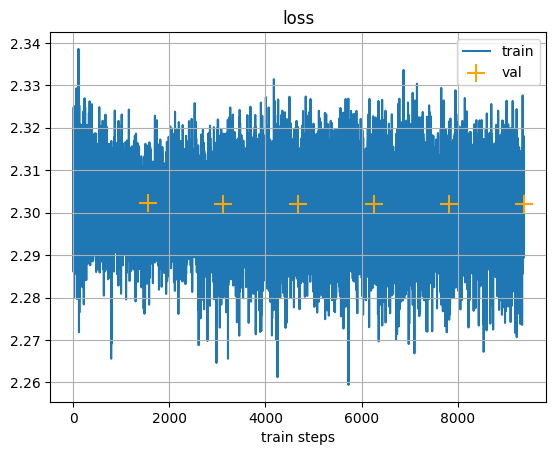

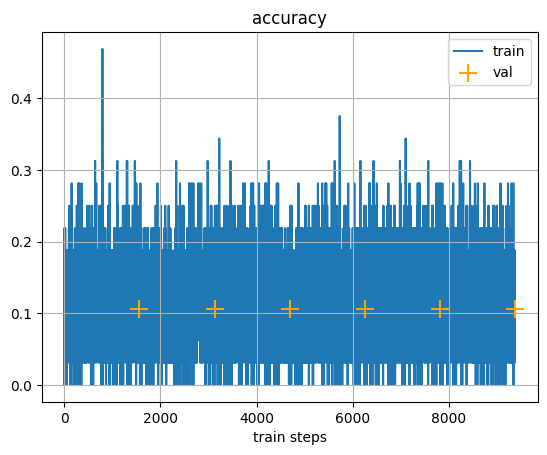

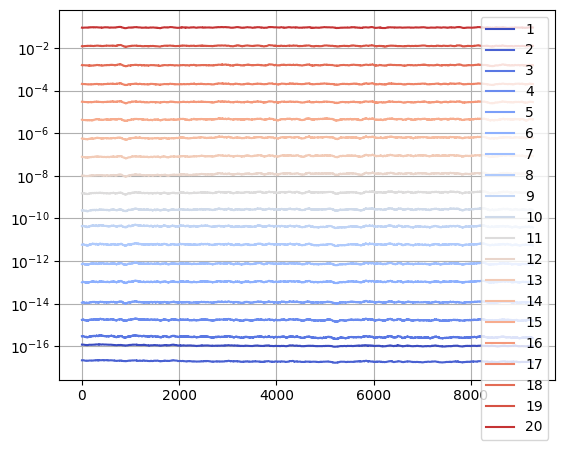

In [71]:
model = DeepDenseNet(n_layers=20, hidden_size=20, activation=nn.Sigmoid())
opt = torch.optim.RMSprop(model.parameters(), lr=0.0001)

train_grad(model, opt, 6)

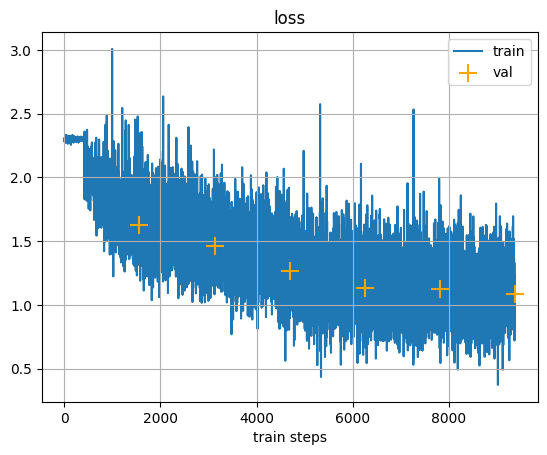

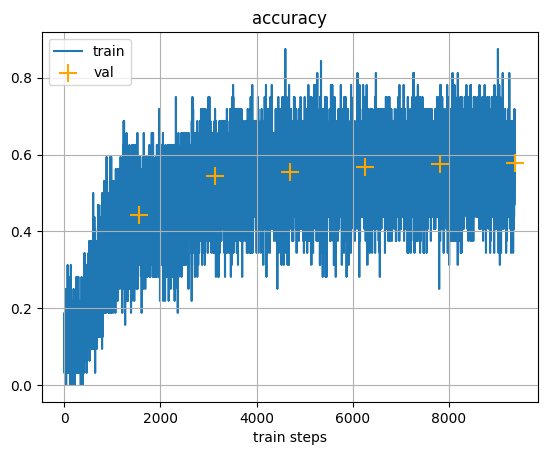

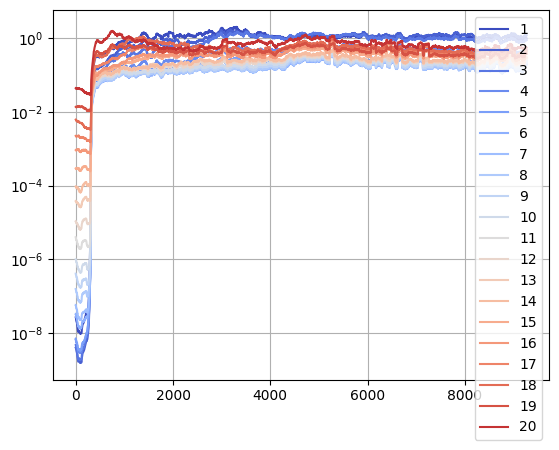

In [76]:
model = DeepDenseNet(n_layers=20, hidden_size=20, activation=nn.ReLU())
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 6)

Вывод: На далеких от выхода слоях в отличие от сигмоидной функции у релу не затухают градиенты

Теперь попробуем добавить в сеть skip-connections (по примеру ResNet) вместо замены сигмоиды на relu и посмотрим, что получится. Запихнуть все слои в nn.Sequential и просто их применить теперь не получится - вместо этого мы их применим вручную. Но положить их в отдельный модуль nn.ModuleList все равно нужно, иначе torch не сможет их найти и оптимизировать.

**Задание 7:** допишите недостающую часть кода ниже.

In [77]:
class DeepDenseResNet(nn.Module):
    def __init__(self, n_layers, hidden_size, activation):
        super().__init__()
        self.activation = activation

        l0 = nn.Linear(X_train.shape[1], hidden_size)
        self.weights = [l0.weight]
        self.layers = [l0]

        for i in range(1, n_layers - 1):
            l = nn.Linear(hidden_size, hidden_size)
            self.layers.append(l)
            self.weights.append(l.weight)

        l = nn.Linear(hidden_size, 10)
        self.layers.append(l)
        self.weights.append(l.weight)

        self.seq = nn.Sequential(*self.layers)

        for l in self.weights:
            l.retain_grad()

    def forward(self, x):
        out  = self.seq[0](x)
        for i in range(1, len(self.seq)):
            if i % 3 == 0:
                out = self.seq[i](out) + out
            else:
                out = self.seq[i](out)


        return F.log_softmax(out, dim=-1)

Убедимся, что такая сеть отлично учится даже на большом числе слоев.

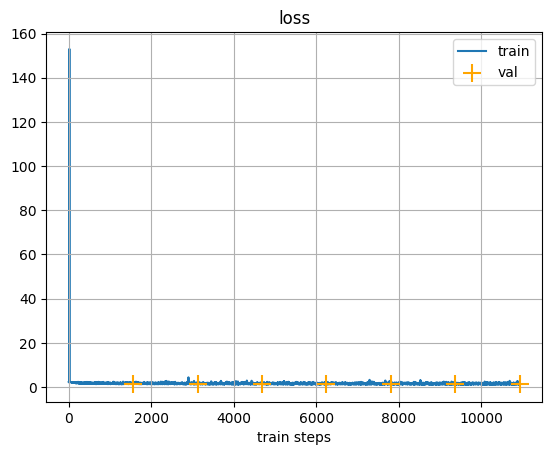

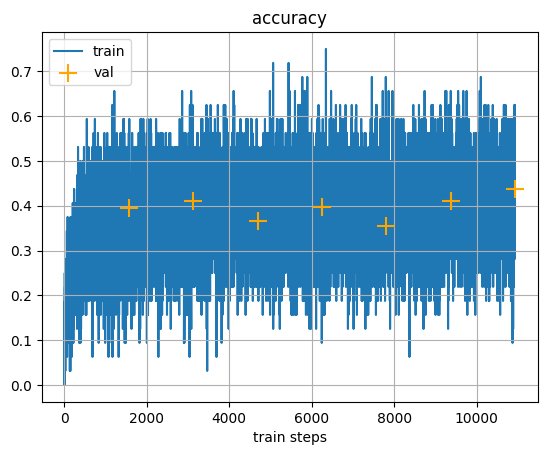

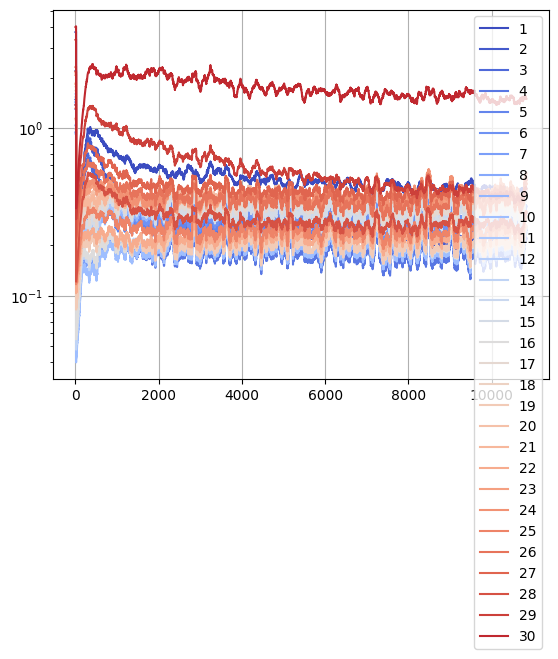

In [78]:
model = DeepDenseResNet(n_layers=30, hidden_size=40, activation=nn.Sigmoid)
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)

train_grad(model, opt, 7)